# Third assignment: Network Robustness


# Part 1: Use small graphs to write the code

1. In the first part, you can use some graphs obtained by using the Networkx library or the library of your choice.
2. For each selected graph (max 2 or 3) you can perform different types of attack: turn off nodes at random, turn off the highest degree nodes, those with the highest pagerank, those with the highest betweenness, ...
2. After each removal, compute new measures, for example the size of the giant component or the diameter of the network and then plot these measures with respect to node failures. In case of networks of large size, often for the giant component S/N is plotted, e.g., the ratio between the size of the giant component and the size of the network.
2. Be careful, some of the functions you will use work only for undirected, connected graphs and therefore you need to instrument your code to work on the entire graph first, and then on the several components after the split of the original graph into smaller clusters.

In [1]:
%matplotlib inline
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from scipy.io import mmread
from scipy import integrate

In [2]:
def remove_random_nodes(G:nx.Graph, num:int=1) -> nx.Graph:
    """Remove a percentage of random nodes from the graph G and return the resulting graph.

    Args:
        G: A networkx graph.
        num: number of nodes to remove from G.

    Returns:
        A networkx graph.
    """
    num = 1 if num < 1 else num
    if G.number_of_nodes() <= 0:
        return G
    
    prev_nodes = G.number_of_nodes()
    if prev_nodes > 0:
        # Get random nodes from G
        nodes = list(G.nodes)
        # random.shuffle(nodes)
        if num > len(nodes):
            num = len(nodes)
        nodes = random.sample(nodes, num)
        # remove num nodes from G (if num > len(nodes), remove all nodes)
        G.remove_nodes_from(nodes[0:num])
    # Return the resulting graph
    return G if G.number_of_nodes() != prev_nodes else nx.Graph()

def remove_highest_degree_node(G:nx.Graph, num:int=1) -> nx.Graph:
    """Remove a percentage of nodes with the highest degree from the graph G and return the resulting graph.
    
    Args:
        G: A networkx graph.
        num: number of nodes to remove from G.
        
    Returns:
        A networkx graph.
    """
    num = 1 if num < 1 else num
    if G.number_of_nodes() <= 0:
        return nx.Graph()
    
    prev_nodes = G.number_of_nodes()
    if prev_nodes > 0:
        # sort nodes by degree
        nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)
        # remove num nodes from G (if num > len(nodes), remove all nodes)
        if num > len(nodes):
            num = len(nodes)
        nodes = [node[0] for node in nodes[0:num]]
        G.remove_nodes_from(nodes)
    # Return the resulting graph
    return ( G if G.number_of_nodes() != prev_nodes else nx.Graph() )

def remove_highest_betweenness_node(G:nx.Graph, num:int=1) -> nx.Graph:
    """Remove the node with the highest betweenness centrality from the graph G and return the resulting graph.
    
    Args:
        G: A networkx graph.
        num: number of nodes to remove from G.
        
    Returns:
        A networkx graph.
    """
    num = 1 if num < 1 else num
    if G.number_of_nodes() <= 0:
        return nx.Graph()
    
    prev_nodes = G.number_of_nodes()
    if prev_nodes > 0:
        # Get the nodes with highest betweenness centrality from G
        nodes = sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)
        if num > len(nodes):
            num = len(nodes)
        # Remove num nodes from G
        nodes = [node[0] for node in nodes[0:num]]
        G.remove_nodes_from(nodes)
        # Return the resulting graph
    return G if G.number_of_nodes() != prev_nodes else nx.Graph()

def remove_highest_pagerank_node(G:nx.Graph, num:int=1) -> nx.Graph:
    """Remove the node with the highest PageRank from the graph G and return the resulting graph.
    
    Args:
        G: A networkx graph.
        num: number of nodes to remove from G.
        
    Returns:
        A networkx graph.
    """
    num = 1 if num < 1 else num
    if G.number_of_nodes() <= 0:
        return nx.Graph()
    
    prev_nodes = G.number_of_nodes()
    if prev_nodes > 0:
        # Get the nodes with the highest PageRank from G
        nodes = sorted(nx.pagerank(G).items(), key=lambda x: x[1], reverse=True)
        # Remove the node from G
        if num > len(nodes):
            num = len(nodes)
        nodes = [node[0] for node in nodes[0:num]]
        G.remove_nodes_from(nodes)
    # Return the resulting graph
    return G

def remove_highest_closeness_node(G: nx.Graph, num:int=1) -> nx.Graph:
    """Remove the node with the highest closeness centrality from the graph G and return the resulting graph.
    
    Args:
        G: A networkx graph.
        num: number of nodes to remove from G.
        
    Returns:
        A networkx graph.
    """
    num = 1 if num < 1 else num
    if G.number_of_nodes() <= 0:
        return nx.Graph()
    
    prev_nodes = G.number_of_nodes()
    if prev_nodes > 0:
        # Get the node with the highest closeness centrality from G
        nodes = sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1], reverse=True)
        # Remove the node from G
        if num > len(nodes):
            num = len(nodes)
        nodes = [node[0] for node in nodes[0:num]]
        G.remove_nodes_from(nodes)
    # Return the resulting graph
    return G if G.number_of_nodes() != prev_nodes else nx.Graph()

def get_lcc(G: nx.Graph) -> nx.Graph:
    """Get the largest connected component of the graph G and return the resulting graph.
    
    Args:
        G: A networkx graph.
        
    Returns:
        A networkx graph.
    """
    # Get the largest connected component from G
    largest_comp = max(nx.connected_components(G), key=len) if len(G) > 0 else set()
    # Return the resulting graph
    return nx.Graph(G.subgraph(largest_comp))

def get_lcc_size(G: nx.Graph) -> int:
    """Deprecated. Use get_lcc instead."""
    raise Exception("Deprecated. Use get_lcc instead.")

def get_diameter(G: nx.Graph) -> int:
    """Get the diameter of the graph G and return the resulting diameter.
    
    Args:
        G: A networkx graph.
        
    Returns:
        An integer.
    """
    if len(G) == 0:
        return 0
    if not nx.is_connected(G):
        G = G.subgraph(max(nx.connected_components(G), key=len))
    return nx.diameter(G) if len(G) > 0 else 0

In [10]:
def attack_random(G: nx.graph, nodes_per_iteration: int):
    g1 = G.copy()
    l1 = []
    d1 = []
    x1 = []
    initial_nodes = g1.number_of_nodes()
    print("g1")
    while g1.number_of_nodes() > 0:
        print(g1.number_of_nodes())
        g1 = get_lcc(g1)
        l1.append( g1.number_of_nodes() )
        d1.append( get_diameter(g1) )
        g1 = remove_random_nodes(g1, nodes_per_iteration)
        res = initial_nodes - g1.number_of_nodes()
        x1.append( res/initial_nodes )
    l1.append(0)
    d1.append(0)
    x1.append(1)
    return l1, d1, x1

def attack_degree(G: nx.graph, nodes_per_iteration: int):
    g2 = G.copy()
    l2 = []
    d2 = []
    x2 = []
    initial_nodes = g2.number_of_nodes()
    print("g2")
    while g2.number_of_nodes() > 0:
        print(g2.number_of_nodes())
        g2 = get_lcc(g2)
        l2.append( g2.number_of_nodes() )
        d2.append( get_diameter(g2) )
        g2 = remove_highest_degree_node(g2, nodes_per_iteration)
        res = initial_nodes - g2.number_of_nodes()
        x2.append( res/initial_nodes )
    l2.append(0)
    d2.append(0)
    x2.append(1)
    return l2, d2, x2

def attack_betweenness(G: nx.graph, nodes_per_iteration: int):
    g3 = G.copy()
    l3 = []
    d3 = []
    x3 = []
    initial_nodes = g3.number_of_nodes()
    print("g3")
    while g3.number_of_nodes() > 0:
        print(g3.number_of_nodes())
        g3 = get_lcc(g3)
        l3.append( g3.number_of_nodes() )
        d3.append( get_diameter(g3) )
        g3 = remove_highest_betweenness_node(g3, nodes_per_iteration)
        res = initial_nodes - g3.number_of_nodes()
        x3.append( res/initial_nodes )
    l3.append(0)
    d3.append(0)
    x3.append(1)
    return l3, d3, x3

def attack_pagerank(G: nx.graph, nodes_per_iteration: int):
    g4 = G.copy()
    l4 = []
    d4 = []
    x4 = []
    initial_nodes = g4.number_of_nodes()
    print("g4")
    while g4.number_of_nodes() > 0:
        print(g4.number_of_nodes())
        g4 = get_lcc(g4)
        l4.append( g4.number_of_nodes() )
        d4.append( get_diameter(g4) )
        g4 = remove_highest_pagerank_node(g4, nodes_per_iteration)
        res = initial_nodes - g4.number_of_nodes()
        x4.append( res/initial_nodes )
    l4.append(0)
    d4.append(0)
    x4.append(1)
    return l4, d4, x4

def attack_closeness(G: nx.graph, nodes_per_iteration: int):
    g5 = G.copy()
    l5 = []
    d5 = []
    x5 = []
    initial_nodes = g5.number_of_nodes()
    print("g5")
    while g5.number_of_nodes() > 0:
        print(g5.number_of_nodes())
        g5 = get_lcc(g5)
        l5.append( g5.number_of_nodes() )
        d5.append( get_diameter(g5) )
        g5 = remove_highest_closeness_node(g5, nodes_per_iteration)
        res = initial_nodes - g5.number_of_nodes()
        x5.append( res/initial_nodes )
    l5.append(0)
    d5.append(0)
    x5.append(1)
    return l5, d5, x5

def plot_results(
        x1:list=None, l1:list=None, d1:list=None,
        x2:list=None, l2:list=None, d2:list=None,
        x3:list=None, l3:list=None, d3:list=None,
        x4:list=None, l4:list=None, d4:list=None,
        x5:list=None, l5:list=None, d5:list=None):
    plt.figure(figsize=(16,16), dpi=300)
    plt.subplot(2, 1, 1)
    plt.title('Largest connected component size vs percentage of nodes removed')
    plt.plot(x1, l1, label='random') if x1 else None
    plt.plot(x2, l2, label='highest degree') if x2 else None
    plt.plot(x3, l3, label='highest betweenness') if x3 else None
    plt.plot(x4, l4, label='highest pagerank') if x4 else None
    plt.plot(x5, l5, label='highest closeness') if x5 else None
    plt.xlabel('percentage of nodes removed')
    plt.ylabel('giant component size')
    plt.grid()
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title('Diameter vs percentage of nodes removed')
    plt.plot(x1, d1, label='random') if x1 else None
    plt.plot(x2, d2, label='highest degree') if x2 else None
    plt.plot(x3, d3, label='highest betweenness') if x3 else None
    plt.plot(x4, d4, label='highest pagerank') if x4 else None
    plt.plot(x5, d5, label='highest closeness') if x5 else None
    plt.xlabel('percentage of nodes removed')
    plt.ylabel('diameter')
    plt.grid()
    plt.legend()
    plt.show()



In [4]:

### Reading graph ###
#n=100
#p=0.1
#k=5
# G=nx.erdos_renyi_graph(n, p)
#G = nx.watts_strogatz_graph(n, k, p)
# nx.draw(G, with_labels=True)

read_file = mmread('power-bcspwr10.mtx')
G = nx.Graph(read_file)
G.remove_edges_from(nx.selfloop_edges(G))
n = G.number_of_nodes()

In [5]:
percentage = 0.01
nodes_per_iteration = int(G.number_of_nodes() * percentage)

In [6]:
l1, d1, x1 = attack_random(G, nodes_per_iteration)

g1
5300
5247
5191
5133
5075
5019
4959
4826
4770
4705
4630
4572
4495
4425
4361
4289
4222
4145
4071
3987
3898
3830
3731
3644
3531
3217
2989
2646
2547
2310
2132
1332
1162
635
458
114


In [7]:
l2, d2, x2 = attack_degree(G, nodes_per_iteration)

g2
5300
5247
5131
5041
4925
4761
4670
4457
4252
4047
3822
2864
2609
2403
1884
695
17


In [8]:
l3, d3, x3 = attack_betweenness(G, nodes_per_iteration)

g3
5300
5247
5192
5130
5027
3040
2979
2894
1534
1165
538
356
28


In [9]:
l4, d4, x4 = attack_pagerank(G, nodes_per_iteration)

g4
5300
5247
5104
4978
4804
4608
4399
4194
3918
3422
3205
2980
2570
2151
1002
423
74


In [11]:
l5, d5, x5 = attack_closeness(G, nodes_per_iteration)

g5
5300
5247
5189
5130
5048
4992
4855
4800
2103
2047
1984
997
931
871
351
140
18


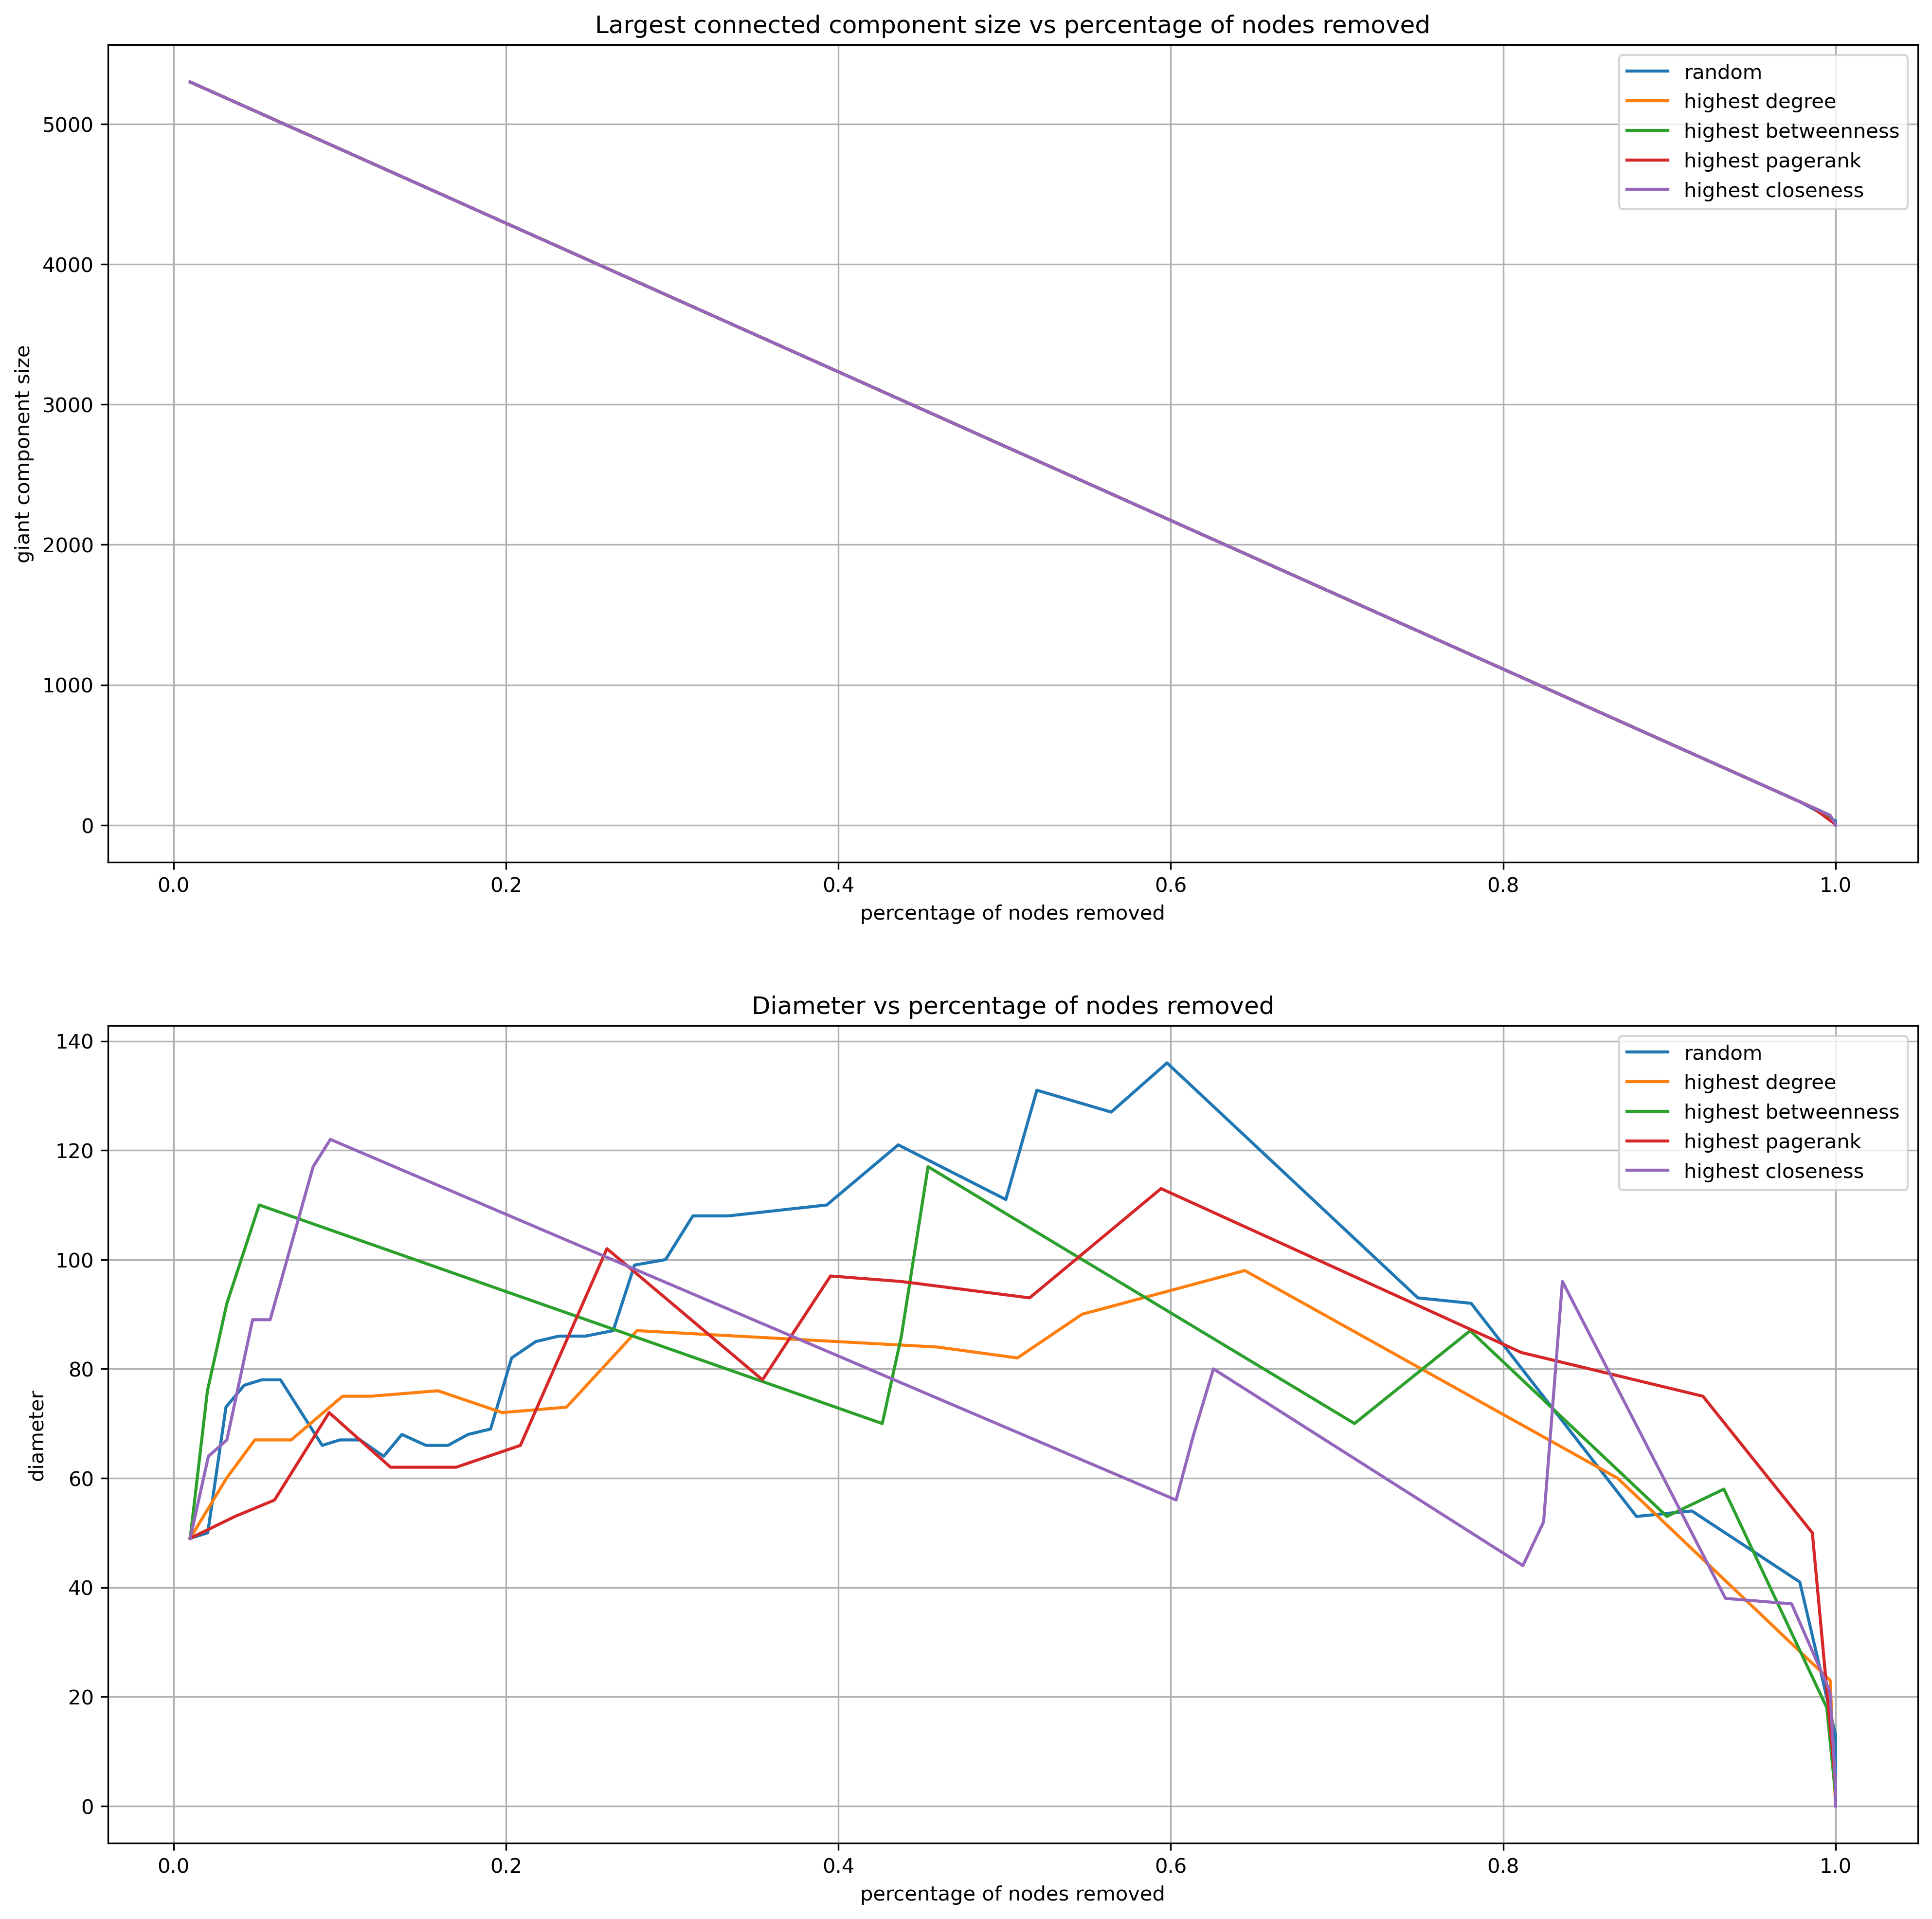

In [12]:
plot_results(
    x1=x1, l1=l1, d1=d1
    ,x2=x2, l2=l2, d2=d2
    ,x3=x3, l3=l3, d3=d3
    ,x4=x4, l4=l4, d4=d4
    ,x5=x5, l5=l5, d5=d5
    )

In [ ]:

import os

def notify(title, text):
    os.system("""
              osascript -e 'display notification "{}" with title "{}"'
              """.format(text, title))

notify("Done", "Python completed")

In [ ]:
# plot G
plt.figure(figsize=(5,5))
plt.title('G')
nx.draw(G, with_labels=False, node_size=10, width=1)
plt.show()


Analysis Before the Attack

In [ ]:
rnd_diameter=[]
rnd_avg_degree=[]
highest_degree_diameter=[]
highest_degree_avg_degree=[]

n=100
p=0.1
G=nx.erdos_renyi_graph(n, p)

In [ ]:
def measure(G):
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
   # print(f"Density: {nx.density(G)}")
   # print(f"Transitivity: {nx.transitivity(G)}")
    print(f"Max Degree: {max(dict(G.degree()).values())}")
    print(f"Min Degree: {min(dict(G.degree()).values())}")
    print(f"Average Degree: {np.mean(list(dict(G.degree()).values()))}")
    rnd_avg_degree.append(np.mean(list(dict(G.degree()).values())))
    highest_degree_avg_degree.append(np.mean(list(dict(G.degree()).values())))
    print(f"Number of components:{nx.number_connected_components(G)}")
    print(f"Assortativity: {nx.degree_assortativity_coefficient(G)}")
    betwenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    degree_centrality = nx.degree_centrality(G)
    print(f"Betweenness centrality max:{max(betwenness_centrality.values())}")
    print(f"Closeness centrality max:{max(closeness_centrality.values())}")
    print(f"Degree centrality max:{max(degree_centrality.values())}")

    if(nx.is_connected(G)):
        print("Graph is connected")
        print(f"Diameter: {nx.diameter(G)}")
        highest_degree_diameter.append(nx.diameter(G))
        rnd_diameter.append(nx.diameter(G))
    else:
        print("Graph is not connected")
        G=G.subgraph(max(nx.connected_components(G), key=len))
        highest_degree_diameter.append(nx.diameter(G))
        rnd_diameter.append(nx.diameter(G))


    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.title("Betweenness distribution")
    plt.hist(betwenness_centrality.values(), bins=100, log=True)

    plt.subplot(132)
    plt.title("Closeness distribution")
    plt.hist(closeness_centrality.values(), bins=100)

    plt.subplot(133)
    plt.title("Degree centrality distribution")
    plt.hist(degree_centrality.values())
    
    plt.show()
    fig, ax = plt.subplots(figsize=(5,3))

    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)
    plt.bar(*np.unique(degree_sequence, return_counts=True))
    #average degree vicino  alla mediana: 7 -> non è scale free

    fig.tight_layout()
    plt.show()

In [ ]:
G_rand=G.copy()
measure(G)

In [ ]:
p=0.0001
val_p=[]
while G.number_of_nodes() > 1:
    val_p.append(p)
    # Calculate the number of nodes to remove
    num_nodes = len(G.nodes())
    nodes_to_remove = round(num_nodes * p)

    # Randomly select nodes to remove
    nodes = list(G.nodes())
    nodes_to_remove = random.sample(nodes, nodes_to_remove)

    # Remove the selected nodes from the graph
    G.remove_nodes_from(nodes_to_remove)
    measure(G)
    p+=0.1


Plot distribution of Diameter and Average degree

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Average degree")
#x labels = val_p normalizzati

plt.xlabel("p")
plt.ylabel("Average degree")
plt.plot(rnd_avg_degree)

plt.subplot(122)
plt.title("Diameter")
plt.xlabel("p")
plt.ylabel("Diameter")
plt.plot(rnd_diameter)

plt.show()

In [ ]:
print(len(val_p))